In [173]:
from IPython.display import display, Latex
import openturns as ot

etude = ot.Study()
etude.load()
etude.setStorageManager(ot.XMLH5StorageManager("study/Project_QI.xml"))
etude.save()

## 3.1 Chargement du cas test
Le cas test est disponible dans le sous-module wingweight_function du module usecases d’OpenTURNS
sous la forme d’une classe appelée WingWeightModel.
1. Charger la classe WingWeightModel.

In [73]:
from openturns.usecases.wingweight_function import WingWeightModel

2. Copier la distribution jointe des sources d’incertitude dans la variable distribution_entrees.

In [157]:
wing_weight_model = WingWeightModel()
distribution_entrees = wing_weight_model.distributionX


In [159]:
# Les distributions
Sw,Wfw,A,Lambda,q,l,tc,Nz,Wdg,Wp = [distribution_entrees.getMarginal(i).getImplementation() for i in range(distribution_entrees.getDimension())]
copule = distribution_entrees.getCopula().getImplementation()


3. Copier la liste des identifiants de ces sources d’incertitude dans la variable nom_sources.


In [155]:
nom_sources = distribution_entrees.getDescription()

for i in range(len(nom_sources)):
    display(Latex(f"{nom_sources[i]} $\sim $ {distribution_entrees.getMarginal(i).getImplementation()}" ))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4. Copier le modèle de masse de l’aile dans la variable model_masse.

In [160]:
model_masse = wing_weight_model.model

5. Vérifier que ce modèle n’a pas été défini à l’aide d’une fonction symbolique. Créer la fonction
symbolique correspondante (utiliser distribution_entrees pour définir les variables dans
le même ordre) et comparer le gradient et la hessienne des deux implémentations du modèle
au point moyen des entrées. Certaines composantes sont-elles entachées d’une grande erreur
relative?

In [161]:
is_symbolic = isinstance(model_masse, ot.SymbolicFunction)

if is_symbolic:
    print("Le modèle est symbolique")
else :
    print("Le modèle n'est pas symbolique")


Le modèle n'est pas symbolique


In [162]:
formula = "0.036*(Sw^0.758)*(Wfw^0.0035)*((A/(cos(Lambda)^2))^0.6)*(q^0.006)*(l^0.04)*(100*tc/cos(Lambda))^(-0.3)*((Nz*Wdg)^0.49)+Sw*Wp"
formula = "0.036*(Sw^0.758)*(Wfw^0.0035)*((A/(cos(Lambda)^2))^0.6)"
symbolic_function = ot.SymbolicFunction(nom_sources, [formula])

In [165]:
mean_inputs = distribution_entrees.getMean()

In [166]:
from openturns import CenteredFiniteDifferenceGradient, CenteredFiniteDifferenceHessian


In [167]:
epsilon = 1e-7
finite_difference_gradient_model = CenteredFiniteDifferenceGradient(epsilon, model_masse.getEvaluation())
finite_difference_hessian_model = CenteredFiniteDifferenceHessian(epsilon, model_masse.getEvaluation())


finite_difference_gradient_symbl = CenteredFiniteDifferenceGradient(epsilon, symbolic_function.getEvaluation())
finite_difference_hessian_symbl = CenteredFiniteDifferenceHessian(epsilon, symbolic_function.getEvaluation())

model_gradient = finite_difference_gradient_model.gradient(mean_inputs)
model_hessian = finite_difference_hessian_model.hessian(mean_inputs)

symbolic_gradient = finite_difference_gradient_symbl.gradient(mean_inputs)
symbolic_hessian = finite_difference_hessian_symbl.hessian(mean_inputs)

In [168]:
# Calculate element-wise relative error for gradient
gradient_relative_error = ot.Matrix(model_gradient.getNbRows(), model_gradient.getNbColumns())
for i in range(model_gradient.getNbRows()):
    for j in range(model_gradient.getNbColumns()):
        gradient_relative_error[i, j] = abs((model_gradient[i, j] - symbolic_gradient[i, j]))

# Calculate element-wise relative error for hessian
hessian_relative_error = ot.Tensor(model_hessian.getNbRows(), model_hessian.getNbColumns(), model_hessian.getNbSheets())
for i in range(model_hessian.getNbRows()):
    for j in range(model_hessian.getNbColumns()):
        for k in range(model_hessian.getNbSheets()):
            hessian_relative_error[i, j, k] = abs((model_hessian[i, j, k] - symbolic_hessian[i, j, k]))

print("Erreur relative du gradient:", gradient_relative_error)
print("Erreur relative de la hessienne:", hessian_relative_error)


Erreur relative du gradient: 10x1
[[   1.14414    ]
 [   0.00339309 ]
 [  18.9021     ]
 [   0          ]
 [   0.0508402  ]
 [  13.7833     ]
 [ 596.394      ]
 [  29.7963     ]
 [   0.0603021  ]
 [ 175          ]]
Erreur relative de la hessienne: 10x10x1
sheet #0
[[    0.0222045    1.39888      2.81997      0            0            0            2.84217      0            0            0         ]
 [    1.39888      1.39888      0            0            1.42109      1.42109      0            0            1.42109      0         ]
 [    2.81997      0            0.0444089    0            1.42109      1.42109     45.4747       2.84217      0            0         ]
 [    0            0            0            7.68274      0            0            0            0            0            0         ]
 [    0            1.42109      1.42109      0            0            1.42109      1.42109      0            1.42109      0         ]
 [    0            1.42109      1.42109      0            1.

6. En générant un échantillon de la distribution des sources d’incertitude de taille telle que
l’évaluation de la fonction symbolique prenne au moins 0.1 secondes (tester progressivement
une taille de 100, 1000 etc) en prenant soin à chaque fois d’initialiser la graine du générateur
aléatoire à la valeur 1234, comparer les temps d’évaluation de l’implémentation via une
fonction symbolique et via une fonction Python.

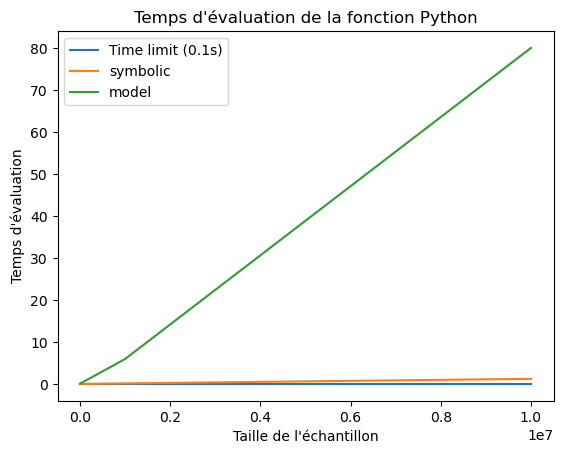

In [169]:
import time
import matplotlib.pyplot as plt
ot.RandomGenerator.SetSeed(1234)

sample_sizes = [100, 1000, 10000, 100000, 1000000, 10000000]
symbolic_time = 0
symbolic_time_list = []
model_time_list = []

for sample_size in sample_sizes:
    sample = distribution_entrees.getSample(sample_size)
    
    duration = 0
    # Mesurez le temps d'évaluation de la fonction Python (model_masse)
    start_time = time.time()
    python_output = model_masse(sample)
    duration = time.time() - start_time
    
    model_time_list.append(duration)

    # if duration >= 0.1:
    #     print(f"Taille de l'échantillon: {sample_size}")
    #     print(f"Temps d'évaluation de la fonction Python: {duration:.5f} secondes")
    #     break

for sample_size in sample_sizes:
    sample = distribution_entrees.getSample(sample_size)
    duration = 0

    #Mesurez le temps d'évaluation de la fonction symbolique
    start_time = time.time()
    symbolic_output = symbolic_function(sample)
    duration  = time.time() - start_time
    symbolic_time_list.append(duration)


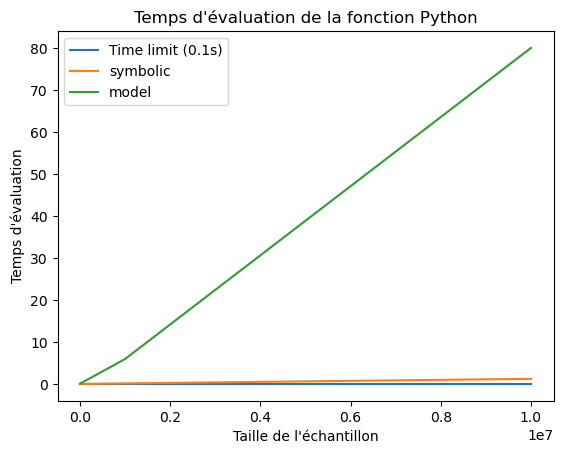

In [170]:

# Add title 
plt.title("Temps d'évaluation de la fonction Python")
plt.xlabel("Taille de l'échantillon")
plt.ylabel("Temps d'évaluation")

#plot parallel line to the right of the plot
plt.plot(sample_sizes, [0.1]*len(sample_sizes), label="Time limit (0.1s)")
plt.plot(sample_sizes, symbolic_time_list, label="symbolic")
plt.plot(sample_sizes, model_time_list, label="model") # Add subtitle to the plot
plt.legend()
plt.show()

On utilisera désormais l’implémentation via une fonction symbolique.
## 3.2 Variables d’entrée et de sortie
7. Créer le vecteur aléatoire X dans la variable X des sources d’incertitude.

In [171]:
X = ot.RandomVector(distribution_entrees)

8. Créer le vecteur aléatoire M dans la variable M correspondant à la masse de l’aile.

In [172]:
M = ot.CompositeRandomVector(model_masse, X)

9. Peut-on obtenir la distribution de `M` à l’aide de l’algèbre des distributions?

> Réponse : Non, on ne peut pas obtenir la distribution de `M` à l'aide de l'algèbre des distributions parceque le modèle est non-linéaire.

10. Calculer la distribution de la masse de la peinture à l’aide de l’algèbre des distributions et
tracer sa densité.